<a href="https://colab.research.google.com/github/danielyzli/morphological-grading/blob/main/embryo_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Exploration

* ```data[index]```
  * ```data[index]['index']``` - (type: int) true index (since there is index skipping)
  * ```data[index]['img']```
    * ```data[index]['img']['0']``` - (type: numpy array) focal 0 image
    * ```data[index]['img']['-15']``` - (type: numpy array) focal -15 image
    * ...and so on
  * ```data[index]['label']```
    * ```data[index]['label'][0]``` - (type: list of ints) labels based on multiple focal
    * ```data[index]['label'][1]``` - (type: list of ints) labels based on single focal




## Open dataset

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open('/content/drive/MyDrive/embryo-grading/morphology_grading_dataset_0606.pickle', 'rb') as handle:
  data = pickle.load(handle)

## Plot label distributions

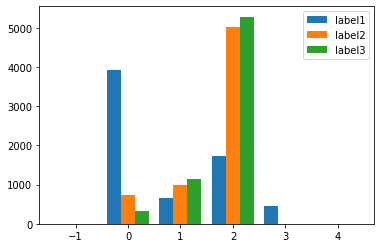

In [ ]:
labellist1, labellist2, labellist3 = [], [], []
for i in range(len(data)):
  labellist1.append(data[i]['label'][1][0])
  labellist2.append(data[i]['label'][1][1])
  labellist3.append(data[i]['label'][1][2])
plt.figure()
bins = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
plt.hist([labellist1, labellist2, labellist3], bins=bins, label=['label1', 'label2', 'label3'])
plt.legend()
plt.show()

## Plot # images per key

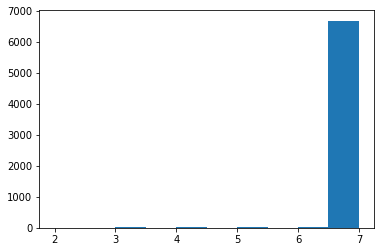

In [ ]:
lengthlist = []
for i in range(len(data)):
  lengthlist.append(len(data[i]['img'].keys()))
plt.figure()
plt.hist(lengthlist)
plt.show()

# Dummy Run Script

## Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import copy
import time

## class single_focal_net

Resnet18 with three FCN outputs

In [2]:
class single_focal_net(nn.Module):

    def __init__(self):
        super(single_focal_net, self).__init__()
        self.backbone_model = models.resnet18(pretrained=True)
        self.backbone_model.fc = nn.Identity()
        self.fc1 = nn.Linear(512, 4)
        self.fc2 = nn.Linear(512, 3)
        self.fc3 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.backbone_model(x)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        return {'out1': out1, 'out2': out2, 'out3': out3}

## class mydata

In [3]:
class mydata(Dataset):

    def __init__(self, datafn, multi_image=False, transform=None):
        # Load .mat data file
        with open(datafn, 'rb') as handle:
            self.data = pickle.load(handle)
        self.multi_image_flag = multi_image
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if not self.multi_image_flag:
            image = self.data[idx]['img']['0']
            labels = self.data[idx]['label'][1]
        else:
            # TODO
            image = self.data[idx]['img']['0']
            labels = self.data[idx]['label'][0]
        if self.transform:
            image = self.transform(image)
        image = image.repeat(3, 1, 1) # turn into RGB because pretrained network expects RGB

        return image, labels

## function focal_loss

In [9]:
def focal_loss(labels, logits, alpha, gamma):
    bcloss = F.binary_cross_entropy_with_logits(input=logits, target=labels, reduction='none')
    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + torch.exp(-1.0 * logits)))

    loss = modulator * bcloss
    weighted_loss = alpha * loss

    return torch.sum(weighted_loss) / torch.sum(labels)

## function cb_loss

Class balanced loss function wrapper.

In [13]:
def cb_loss(labels, logits, samples_per_class, loss_type, beta, gamma, device):
    num_class = len(samples_per_class)
    labels_oh = F.one_hot(labels, num_class).float()
    weights = (1.0 - beta) / (np.array(1.0 - np.power(beta, samples_per_class)))
    weights = weights / np.sum(weights) * num_class
    weights = torch.tensor(weights).float()
    weights = weights.to(device)
    weights = weights.unsqueeze(0)
    weights = weights.repeat(labels_oh.shape[0], 1) * labels_oh
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1, num_class)

    if loss_type == "focal":
        cb_loss = focal_loss(labels_oh, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input=logits, target=labels_oh, weights=weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim = 1)
        cb_loss = F.binary_cross_entropy(input=pred, target=labels_oh, weight=weights)

    return cb_loss

## function train_model

In [11]:
def train_model(model, dataloaders, optimizer, criterion, lr_scheduler, num_epochs, samples_per_class, loss_type, loss_beta, loss_gamma, device):
  since = time.time()

  train_loss1_vec, train_loss2_vec, train_loss3_vec = [], [], []
  val_loss1_vec, val_loss2_vec, val_loss3_vec = [], [], []
  train_acc1_vec, train_acc2_vec, train_acc3_vec = [], [], []
  val_acc1_vec, val_acc2_vec, val_acc3_vec = [], [], []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    print('lr: {}'.format(optimizer.param_groups[0]['lr']))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss1, running_loss2, running_loss3 = 0, 0, 0
      running_corrects1, running_corrects2, running_corrects3 = 0, 0, 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        label1 = torch.from_numpy(np.asarray(labels[0]).astype('long')).to(device)
        label2 = torch.from_numpy(np.asarray(labels[1]).astype('long')).to(device)
        label3 = torch.from_numpy(np.asarray(labels[2]).astype('long')).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          # loss1 = criterion(outputs['out1'], label1)
          # loss2 = criterion(outputs['out2'], label2)
          # loss3 = criterion(outputs['out3'], label3)
          loss1 = cb_loss(label1, outputs['out1'], samples_per_class[0], loss_type, loss_beta, loss_gamma, device)
          loss2 = cb_loss(label2, outputs['out2'], samples_per_class[1], loss_type, loss_beta, loss_gamma, device)
          loss3 = cb_loss(label3, outputs['out3'], samples_per_class[2], loss_type, loss_beta, loss_gamma, device)
          loss = (loss1 + loss2 + loss3)/3

          _, preds1 = torch.max(outputs['out1'], 1)
          _, preds2 = torch.max(outputs['out2'], 1)
          _, preds3 = torch.max(outputs['out3'], 1)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss1 += loss1.item() * inputs.size(0)
        running_loss2 += loss2.item() * inputs.size(0)
        running_loss3 += loss3.item() * inputs.size(0)
        running_corrects1 += torch.sum(preds1 == label1).cpu().numpy()
        running_corrects2 += torch.sum(preds2 == label2).cpu().numpy()
        running_corrects3 += torch.sum(preds3 == label3).cpu().numpy()

      if phase == 'train':
        lr_scheduler.step()

      epoch_loss1 = running_loss1 / len(dataloaders[phase].sampler)
      epoch_loss2 = running_loss2 / len(dataloaders[phase].sampler)
      epoch_loss3 = running_loss3 / len(dataloaders[phase].sampler)
      epoch_acc1 = running_corrects1 / len(dataloaders[phase].sampler)
      epoch_acc2 = running_corrects2 / len(dataloaders[phase].sampler)
      epoch_acc3 = running_corrects3 / len(dataloaders[phase].sampler)
      print('({})\nLoss1: {:.4f}   Loss2: {:.4f}   Loss3: {:.4f}\nAcc1: {:.4f}   Acc2: {:.4f}   Acc3: {:.4f}'.format(phase, epoch_loss1, epoch_loss2, epoch_loss3, epoch_acc1, epoch_acc2, epoch_acc3))

      # deep copy the model
      if phase == 'val' and (epoch_acc1 + epoch_acc2 + epoch_acc3)/3 > best_acc:
        best_acc = (epoch_acc1 + epoch_acc2 + epoch_acc3)/3
        best_model_wts = copy.deepcopy(model.state_dict())
      # record history
      if phase == 'train':
        train_loss1_vec.append(epoch_loss1)
        train_loss2_vec.append(epoch_loss2)
        train_loss3_vec.append(epoch_loss3)
        train_acc1_vec.append(epoch_acc1)
        train_acc2_vec.append(epoch_acc2)
        train_acc3_vec.append(epoch_acc3)
      else:
        val_loss1_vec.append(epoch_loss1)
        val_loss2_vec.append(epoch_loss2)
        val_loss3_vec.append(epoch_loss3)
        val_acc1_vec.append(epoch_acc1)
        val_acc2_vec.append(epoch_acc2)
        val_acc3_vec.append(epoch_acc3)

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, {'train_loss': [train_loss1_vec, train_loss2_vec, train_loss3_vec], 'train_acc': [train_acc1_vec, train_acc2_vec, train_acc3_vec], 'val_loss': [val_loss1_vec, val_loss2_vec, val_loss3_vec], 'val_acc': [val_acc1_vec, val_acc2_vec, val_acc3_vec]}

## function plot_training_curve

In [5]:
def plot_training_curve(history_dict, num_epochs):
  titles = ['Label 1 (dev. stage)', 'Label 2 (inner cell mass)', 'Label 3 (trophectoderm)']
  epochs = range(num_epochs)
  for i in range(3):
    plt.figure()
    plt.plot(epochs, history_dict['train_loss'][i], label='train loss')
    plt.plot(epochs, history_dict['train_acc'][i], label='train acc')
    plt.plot(epochs, history_dict['val_loss'][i], label='val loss')
    plt.plot(epochs, history_dict['val_acc'][i], label='val acc')
    plt.title(titles[i])
    plt.legend()
    plt.xlabel('Epochs')
  plt.show()

## Parameters

In [6]:
np_random_seed = 64
datafn = '/content/drive/MyDrive/embryo-grading/morphology_grading_dataset_0606.pickle'
batch_size = 32
learning_rate = 0.1
momentum = 0.9
lr_step = 10
lr_gamma = 0.5
shuffle_dataset = True
validation_split = 0.2
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.3927], [0.2723])])
num_epochs = 100
loss_type = 'focal'
loss_beta = 0.001
loss_gamma = 0.001

## Training script

Dataloader structure
* Each index of ```loader[0-(#batches-1)]``` contains:
  * ```images[0-(batch_size-1)]``` 
  * ```labels[0,1,2]``` which contains ```label1[0-(batch_size-1)]```, ```label2[0-(batch_size-1)]```, and ```label3[0-(batch_size-1)]``` (one-hot)
  * The last batch may not be complete i.e. have length shorter than ```batch_size```

In [7]:
# Dataset
dataset = mydata(datafn, multi_image=False, transform=trans)

Epoch 0/99
----------
lr: 0.001
(train)
Loss1: 1.2880   Loss2: 1.0902   Loss3: 0.8931
Acc1: 0.7222   Acc2: 0.7296   Acc3: 0.7992
(val)
Loss1: 0.9149   Loss2: 0.9227   Loss3: 0.7547
Acc1: 0.8050   Acc2: 0.7326   Acc3: 0.8161

Epoch 1/99
----------
lr: 0.001
(train)
Loss1: 0.8567   Loss2: 0.8659   Loss3: 0.7095
Acc1: 0.8171   Acc2: 0.7575   Acc3: 0.8252
(val)
Loss1: 0.8093   Loss2: 0.8934   Loss3: 0.7145
Acc1: 0.8139   Acc2: 0.7437   Acc3: 0.8235

Epoch 2/99
----------
lr: 0.001
(train)
Loss1: 0.7622   Loss2: 0.8242   Loss3: 0.6598
Acc1: 0.8379   Acc2: 0.7724   Acc3: 0.8389
(val)
Loss1: 0.7418   Loss2: 0.8455   Loss3: 0.6745
Acc1: 0.8353   Acc2: 0.7511   Acc3: 0.8486

Epoch 3/99
----------
lr: 0.001
(train)
Loss1: 0.7183   Loss2: 0.7961   Loss3: 0.6250
Acc1: 0.8523   Acc2: 0.7781   Acc3: 0.8474
(val)
Loss1: 0.7210   Loss2: 0.8439   Loss3: 0.6546
Acc1: 0.8412   Acc2: 0.7555   Acc3: 0.8545

Epoch 4/99
----------
lr: 0.001
(train)
Loss1: 0.6816   Loss2: 0.7691   Loss3: 0.5872
Acc1: 0.8619  

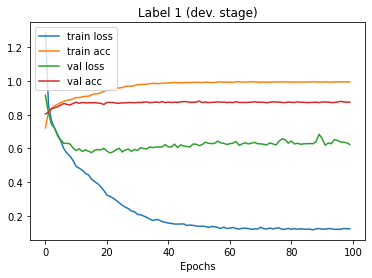

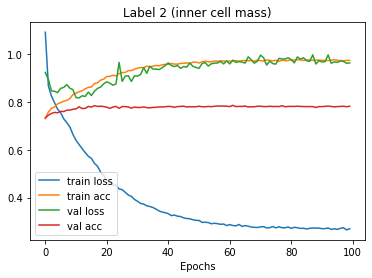

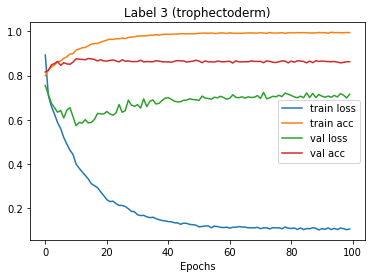

In [14]:
# Split into train and test
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
  np.random.seed(np_random_seed)
  np.random.shuffle(indices)
train_indices = indices[split:]
val_indices = indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Load data
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
# fortesting_loader = DataLoader(dataset, batch_size=batch_size)

samples_per_class = [[0, 0, 0, 0], [0, 0, 0], [0, 0, 0]]
for _, labels in train_loader:
  for i in range(3):
    for j in range(len(samples_per_class[i])):
      num_mask = np.asarray(labels[i]) == j
      samples_per_class[i][j] += len(labels[i][num_mask])

# Instantiate network
model = single_focal_net()

# Use CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)

# Training setup
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)
criterion = nn.CrossEntropyLoss()

# Run training
model, history_dict = train_model(model, {'train': train_loader, 'val': val_loader}, optimizer, criterion, lr_scheduler, num_epochs, samples_per_class, loss_type, loss_beta, loss_gamma, device)

# Visualize the training
plot_training_curve(history_dict, num_epochs)

## Utility functions

### function get_mean_std

Used for normalization.

For ```np_random_seed = 64``` and ```validation_split = 0.2```:

* All data - mean = 0.3933, std = 0.2727
* Train - mean = 0.3927, std = 0.2723
* Val - mean = 0.3961, std = 0.2743

Normalization and denormalization operations should all use training set values.

In [ ]:
def get_mean_std(loader):
  #VAR[X] = E[X**2] - E[X]**2
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  for image, labels in loader:
    channels_sum += torch.mean(image, dim=[0,2,3])
    channels_squared_sum += torch.mean(image**2, dim=[0,2,3])
    num_batches = num_batches + 1
    print('num_batches: {}'.format(num_batches))
  mean = channels_sum / num_batches
  std = (channels_squared_sum/num_batches - mean**2)**0.5
  return mean, std

### function unnormalize

Used for visualization.

In [ ]:
def unnormalize(img, mean=[0.3927, 0.3927, 0.3927], std=[0.2723, 0.2723, 0.2723]):
  for t, m, s in zip(img, mean, std):
    t.mul_(s).add_(m)
  return img

### function show_batch

Visualizes batch of images in grid.

In [ ]:
def show_data(loader, batch_to_visualize):
  for i, [images, labels] in enumerate(loader):
    if (i == batch_to_visualize):
      # lbl = [labels[0][index_to_visualize], labels[1][index_to_visualize], labels[2][index_to_visualize]]
      for img in images:
        img = unnormalize(img)
      grid = utils.make_grid(images)
      plt.figure()
      plt.imshow(grid.numpy().transpose((1, 2, 0)))
      plt.axis('off')
      plt.ioff()
      plt.show()
      break